In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

In [19]:
import cv2
import numpy as np
from rembg import remove

# 去除背景（百边填充）
def rembgImg(image):
    return remove(image)

# 固定尺寸
def resizeImg(image, height=1200):
    h, w = image.shape[:2]
    pro = height / h
    size = (int(w * pro), int(height))
    img = cv2.resize(image, size)
    return img


# 边缘检测
def getCanny(image):
    # 高斯模糊
    binary = cv2.GaussianBlur(image, (3, 3), 2, 2)
    # 边缘检测
    binary = cv2.Canny(binary, 60, 240, apertureSize=3)
    # 膨胀操作，尽量使边缘闭合
    kernel = np.ones((3, 3), np.uint8)
    binary = cv2.dilate(binary, kernel, iterations=1)
    return binary


# 求出面积最大的轮廓
def findMaxContour(image):
    # 寻找边缘
    contours = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[0]
    # 计算面积
    max_area = 0.0
    max_contour = []
    for contour in contours:
        currentArea = cv2.contourArea(contour)
        if currentArea > max_area:
            max_area = currentArea
            max_contour = contour
    return max_contour, max_area


# 多边形拟合凸包的四个顶点
def getBoxPoint(contour):
    # 多边形拟合凸包
    hull = cv2.convexHull(contour)
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(hull, epsilon, True)
    approx = approx.reshape((len(approx), 2))
    return approx


# 适配原四边形点集
def adaPoint(box, pro):
    box_pro = box
    if pro != 1.0:
        box_pro = box/pro
    box_pro = np.trunc(box_pro)
    return box_pro


# 四边形顶点排序，[top-left, top-right, bottom-right, bottom-left]
def orderPoints(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect


# 计算长宽
def pointDistance(a, b):
    return int(np.sqrt(np.sum(np.square(a - b))))


# 透视变换
def warpImage(image, box):
    w, h = pointDistance(box[0], box[1]), \
           pointDistance(box[1], box[2])
    dst_rect = np.array([[0, 0],
                         [w - 1, 0],
                         [w - 1, h - 1],
                         [0, h - 1]], dtype='float32')
    M = cv2.getPerspectiveTransform(box, dst_rect)
    warped = cv2.warpPerspective(image, M, (w, h))
    return warped

def extract_document(filepath, outpath=None):
    """提取票据主要区域并保存（如果outpath提供）"""
    image = cv2.imread(filepath)
    
    # 白边填充背景
    image = rembgImg(image)
    
    # 尺寸变化
    img = resizeImg(image)
    ratio = 1200 / image.shape[0]   # 放缩尺寸
    
    # 边缘检测
    binary_img = getCanny(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    
    # 最大轮廓检测
    max_contour, max_area = findMaxContour(binary_img)
    
    # 轮廓四顶点拟合
    boxes = getBoxPoint(max_contour)
    
    # 还原原顶点
    boxes = adaPoint(boxes, ratio)
    
    # 顶点排序
    boxes = orderPoints(boxes)
    
    # 透视变化
    warped = warpImage(image, boxes)
    
    if outpath:
        cv2.imwrite(outpath, warped)
    
    return warped, boxes



In [27]:
# ========== 票据相似度比较部分 ==========
def preprocess_for_comparison(image, target_size=(800, 600)):
    """预处理图像用于比较"""
    # 统一尺寸
    resized = cv2.resize(image, target_size)
    
    # 灰度化
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    
    # 自适应二值化
    binary = cv2.adaptiveThreshold(
        gray, 255, 
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY_INV, 11, 2
    )
    
    return binary

def compare_documents(img1, img2, threshold=0.25):
    """
    比较两张提取后的票据图像
    :param img1: 第一张票据图像
    :param img2: 第二张票据图像
    :param threshold: 相似度阈值（0-1之间）
    :return: (是否相同, 相似度分数, 可视化图像)
    """
    # 预处理
    img1_prep = preprocess_for_comparison(img1)
    img2_prep = preprocess_for_comparison(img2)
    
    # 方法1: 结构相似性 (SSIM)
    def calculate_ssim(img1, img2):
        from skimage.metrics import structural_similarity as ssim
        return ssim(img1, img2, data_range=img2.max() - img2.min())
    
    ssim_score = calculate_ssim(img1_prep, img2_prep)
    
    # 方法2: ORB特征匹配
    def orb_feature_matching(img1, img2):
        # 初始化ORB检测器
        orb = cv2.ORB_create(nfeatures=10000)
        
        # 检测关键点和计算描述符
        kp1, des1 = orb.detectAndCompute(img1, None)
        kp2, des2 = orb.detectAndCompute(img2, None)
        
        # 如果没有足够的特征点，返回0
        if des1 is None or des2 is None or len(des1) < 10 or len(des2) < 10:
            return 0, 0, None
        
        # 创建BF匹配器
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
        matches = bf.knnMatch(des1, des2, k=2)
        
        # 应用比率测试
        good_matches = []
        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                good_matches.append(m)
        
        # 计算匹配率
        match_rate = len(good_matches) / min(len(des1), len(des2))
        
        # 绘制匹配结果
        if good_matches:
            matched_img = cv2.drawMatches(
                cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR), kp1,
                cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR), kp2,
                good_matches[:50], None,  # 最多显示50个匹配点
                flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
            )
        else:
            matched_img = None
        
        return match_rate, len(good_matches), matched_img
    
    orb_rate, num_matches, orb_img = orb_feature_matching(img1_prep, img2_prep)
    
    # 方法3: 直方图比较
    def histogram_comparison(img1, img2):
        # 计算直方图
        hist1 = cv2.calcHist([img1], [0], None, [256], [0, 256])
        hist2 = cv2.calcHist([img2], [0], None, [256], [0, 256])
        
        # 归一化
        cv2.normalize(hist1, hist1, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
        cv2.normalize(hist2, hist2, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
        
        # 计算直方图相关性
        return cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)
    
    hist_score = histogram_comparison(img1_prep, img2_prep)
    
    # 综合评分 (加权平均)
    weights = {
        'ssim': 0.5,
        'orb': 0.3,
        'hist': 0.2
    }
    
    # 如果ORB匹配失败，调整权重
    if orb_rate == 0:
        weights = {
            'ssim': 0.7,
            'orb': 0.0,
            'hist': 0.3
        }
        orb_rate = 0
    
    similarity_score = (
        weights['ssim'] * ssim_score +
        weights['orb'] * orb_rate +
        weights['hist'] * hist_score
    )
    
    # 判断结果
    is_same = similarity_score > threshold
    
    # 创建可视化结果
    plt.figure(figsize=(15, 10))
    
    # 原始图像1
    plt.subplot(231)
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    plt.title('提取的票据1')
    plt.axis('off')
    
    # 原始图像2
    plt.subplot(232)
    plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    plt.title('提取的票据2')
    plt.axis('off')
    
    # 预处理图像1
    plt.subplot(233)
    plt.imshow(img1_prep, cmap='gray')
    plt.title('预处理后的票据1')
    plt.axis('off')
    
    # 预处理图像2
    plt.subplot(234)
    plt.imshow(img2_prep, cmap='gray')
    plt.title('预处理后的票据2')
    plt.axis('off')
    
    # 特征匹配结果
    if orb_img is not None:
        plt.subplot(235)
        plt.imshow(cv2.cvtColor(orb_img, cv2.COLOR_BGR2RGB))
        plt.title(f'ORB特征匹配 ({num_matches}个匹配点)')
        plt.axis('off')
    
    # 评分结果
    plt.subplot(236)
    plt.text(0.1, 0.6, f'综合相似度: {similarity_score:.2f}', fontsize=14)
    plt.text(0.1, 0.4, f'SSIM相似度: {ssim_score:.2f}', fontsize=12)
    plt.text(0.1, 0.3, f'ORB匹配率: {orb_rate:.2f}', fontsize=12)
    plt.text(0.1, 0.2, f'直方图相似度: {hist_score:.2f}', fontsize=12)
    plt.text(0.1, 0.1, f'判定结果: {"same" if is_same else "difference"}', 
             fontsize=16, color='green' if is_same else 'red')
    plt.axis('off')
    
    plt.suptitle(f'票据比对结果 (阈值={threshold})', fontsize=16)
    plt.tight_layout()
    
    return is_same, similarity_score

# ========== Jupyter Notebook 使用示例 ==========
def compare_tickets(photo_path, scan_path, threshold=0.25):
    """完整流程：提取票据并比较"""
    # 1. 提取照片中的票据
    extracted_photo, _ = extract_document(photo_path)
    
    # 2. 读取扫描件
    scan_img = cv2.imread(scan_path)
    
    # 3. 比较两张票据
    return compare_documents(extracted_photo, scan_img, threshold)


C:\Users\cxw\AppData\Local\Temp\ipykernel_17472\1238073676.py:164: UserWarning: Glyph 25552 (\N{CJK UNIFIED IDEOGRAPH-63D0}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cxw\AppData\Local\Temp\ipykernel_17472\1238073676.py:164: UserWarning: Glyph 21462 (\N{CJK UNIFIED IDEOGRAPH-53D6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cxw\AppData\Local\Temp\ipykernel_17472\1238073676.py:164: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cxw\AppData\Local\Temp\ipykernel_17472\1238073676.py:164: UserWarning: Glyph 31080 (\N{CJK UNIFIED IDEOGRAPH-7968}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cxw\AppData\Local\Temp\ipykernel_17472\1238073676.py:164: UserWarning: Glyph 25454 (\N{CJK UNIFIED IDEOGRAPH-636E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cxw\AppData\Local\Temp\ipykernel_17472\1238073676.py:164: UserWarning: Glyph 39044 (\N{CJK 

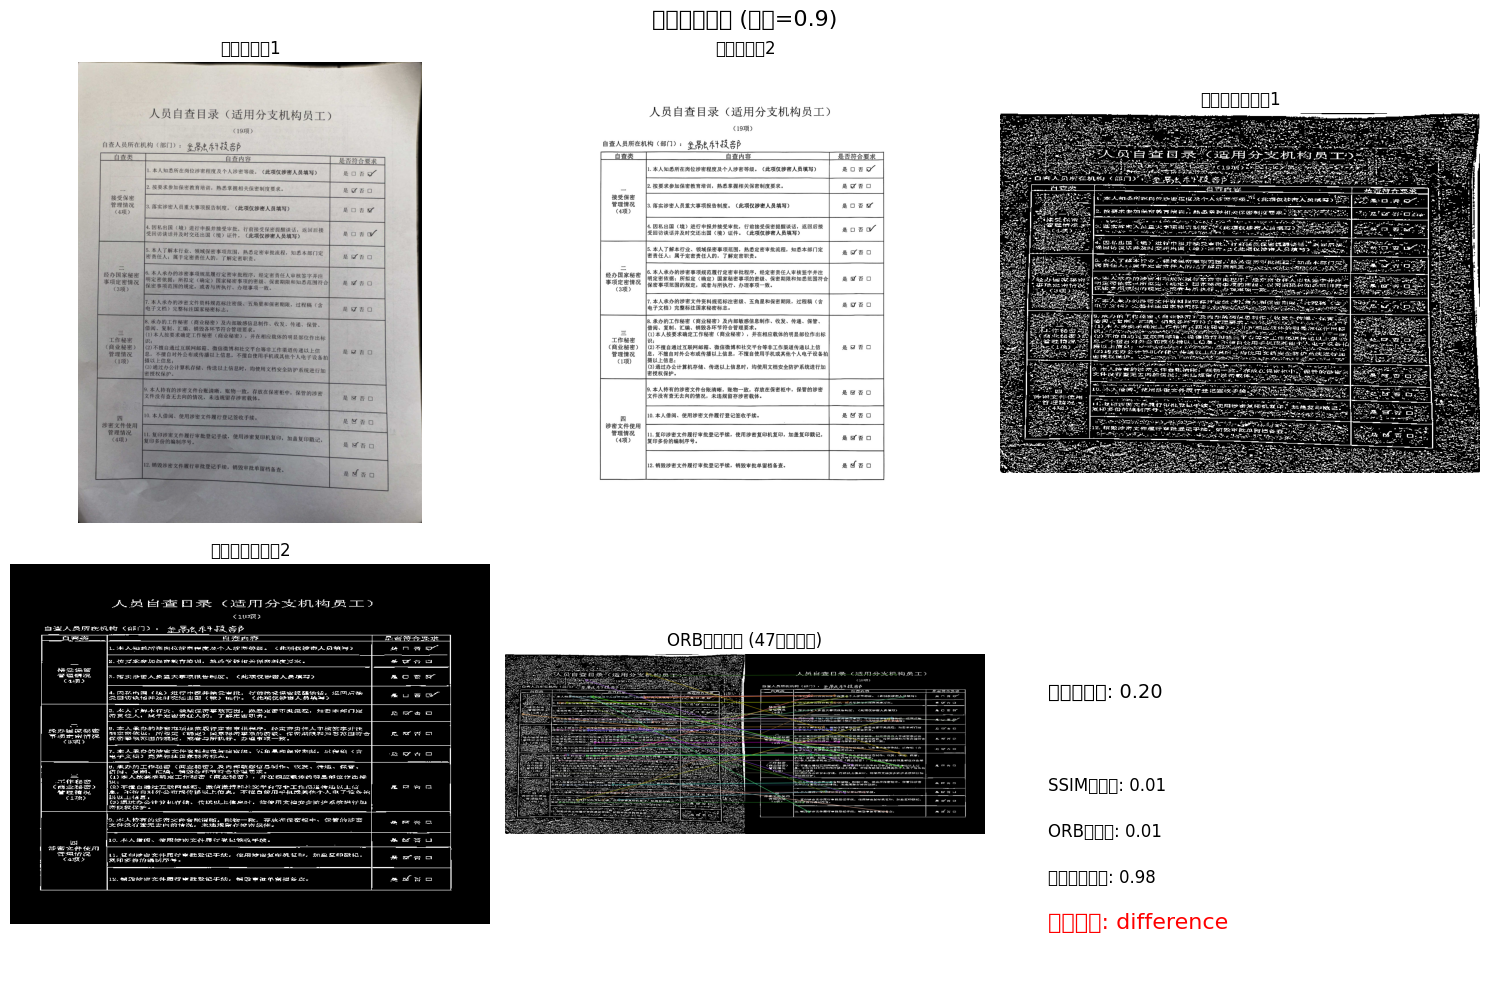

In [28]:
result, score = compare_tickets("../20250814091428.jpg", "../scan20250814091447.jpg", threshold=0.9)
plt.show()  # 显示比较结果